In [6]:
import params
import curveTreeDB
allModels = curveTreeDB.getValidModels(params.treeModels, returnEntireObject=True)

In [12]:
import pandas as pd
cleanedModels = []
for item in allModels:
#     del item["model"]
    try:
        del item["series"]
    except:
        pass
    try:
        print(item["IS_PROFITABILITY"])
    except:
        continue
    if item["IS_PROFITABILITY SLIPPAGE"] < 0.51:
        continue
#     del item["ticker"]
    itemKeys= list(item.keys())
    for key in itemKeys:
        if key.startswith("OOS") and key != "OOS_PROFITABILITY" and key != "OOS_ALPHA":
            del item[key]
    cleanedModels.append(item)


0.519627681100769
0.3037578288100209
0.23181580324437467
0.4862475442043222
0.29732028923862186
0.26480263157894735
0.46141124586549065
0.4888888888888889
0.4983407079646018
0.235678391959799
0.42262739597942967
0.453646477132262
0.3636871508379888
0.35691987513007284
0.3613673358654368
0.48274002157497303
0.2218004338394794
0.45911330049261084
0.36595022624434387
0.26901031715705004
0.5316523605150214
0.25625
0.5177865612648221
0.3778519755147468
0.4060968971148612
0.46601941747572817
0.4630515683147262
0.4793733681462141
0.26492942453854507
0.4588815789473684
0.413290113452188
0.48647214854111404
0.45232172470978443
0.5034324942791762
0.4782608695652174
0.29147524247064827
0.4969123095924249
0.4088330632090762
0.2914046121593291
0.3228
0.4706504494976203
0.26078132927447994
0.519453207150368
0.3427353230567399
0.466793893129771
0.27332965212589727
0.2937365010799136
0.32325383304940375
0.48787210584343993
0.2301967038809144
0.2841269841269841
0.46292585170340683
0.49394939493949397
0

In [13]:
len(cleanedModels)

153

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_PROFITABILITY


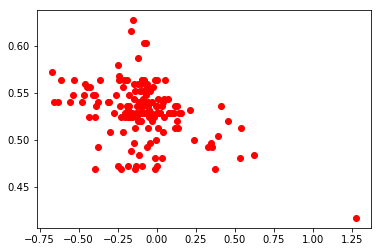

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_ALPHA


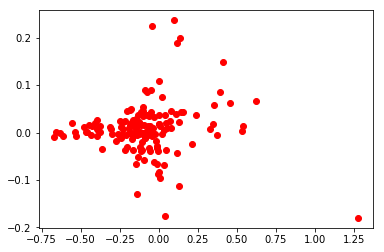

IS_25TH PERCENTILE SHARPE OOS_PROFITABILITY


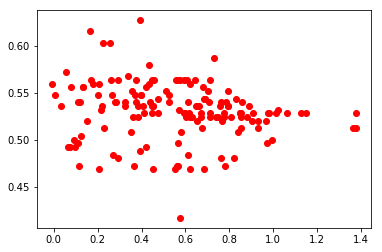

IS_25TH PERCENTILE SHARPE OOS_ALPHA


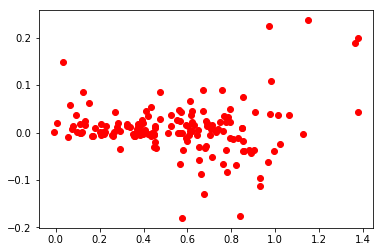

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_PROFITABILITY


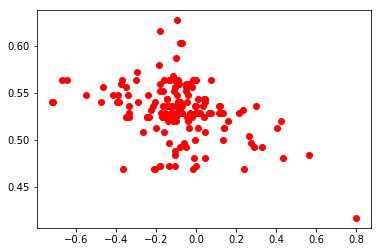

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_ALPHA


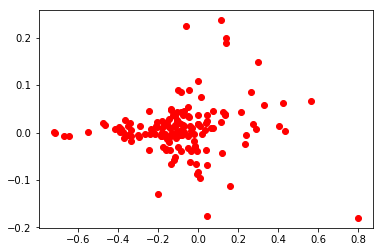

IS_ACTIVE PROFITABILITY OOS_PROFITABILITY


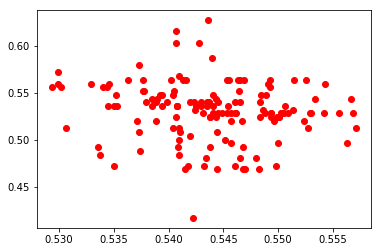

IS_ACTIVE PROFITABILITY OOS_ALPHA


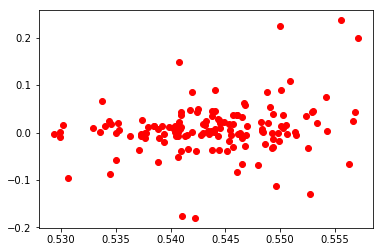

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_PROFITABILITY


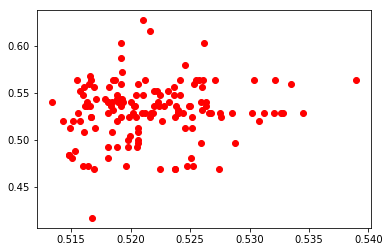

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_ALPHA


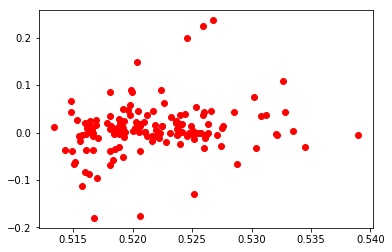

IS_ACTIVITY OOS_PROFITABILITY


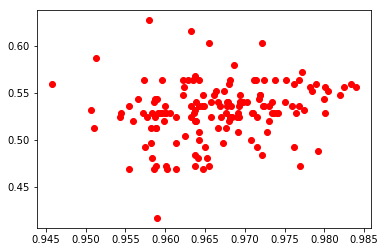

IS_ACTIVITY OOS_ALPHA


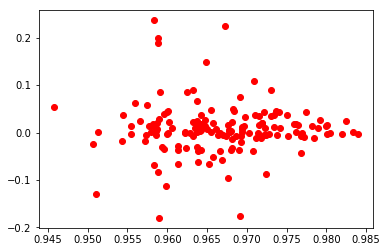

IS_ALPHA OOS_PROFITABILITY


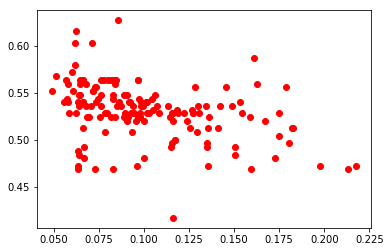

IS_ALPHA OOS_ALPHA


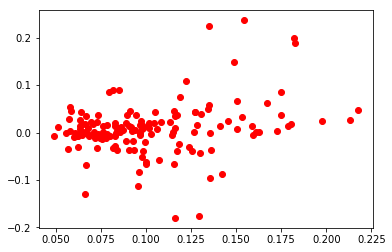

IS_ALPHA SLIPPAGE OOS_PROFITABILITY


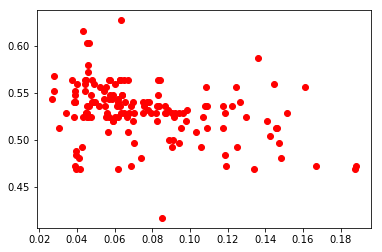

IS_ALPHA SLIPPAGE OOS_ALPHA


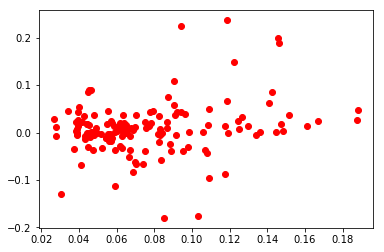

IS_ANNUALIZED RETURN OOS_PROFITABILITY


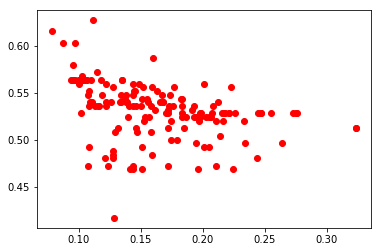

IS_ANNUALIZED RETURN OOS_ALPHA


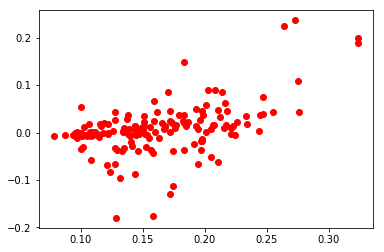

IS_BETA OOS_PROFITABILITY


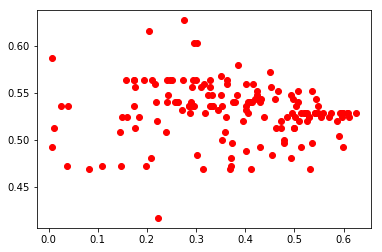

IS_BETA OOS_ALPHA


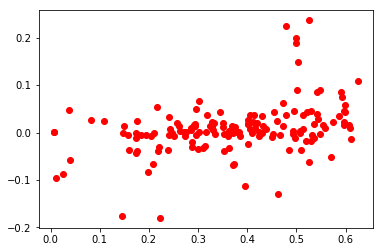

IS_EXTREME STABILITY OOS_PROFITABILITY


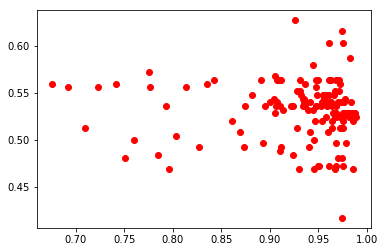

IS_EXTREME STABILITY OOS_ALPHA


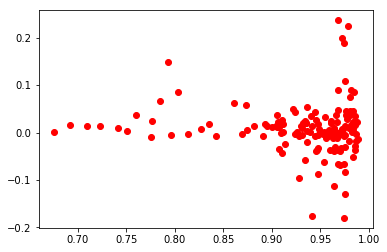

IS_EXTREME STABILITY ROLLING 600 OOS_PROFITABILITY


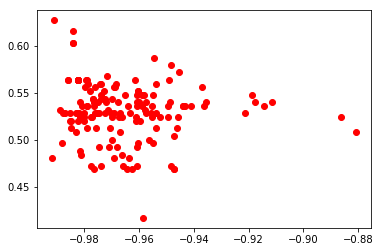

IS_EXTREME STABILITY ROLLING 600 OOS_ALPHA


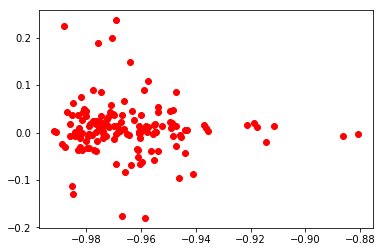

IS_FACTOR SHARPE OOS_PROFITABILITY


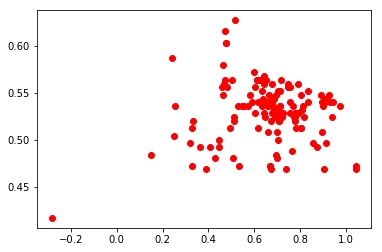

IS_FACTOR SHARPE OOS_ALPHA


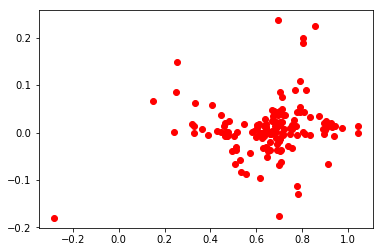

IS_MIN ROLLING SHARPE OOS_PROFITABILITY


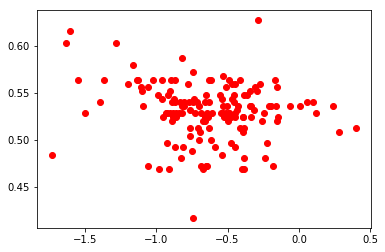

IS_MIN ROLLING SHARPE OOS_ALPHA


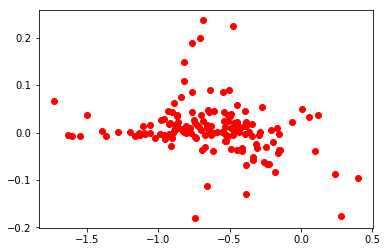

IS_ONE STD SHARPE OOS_PROFITABILITY


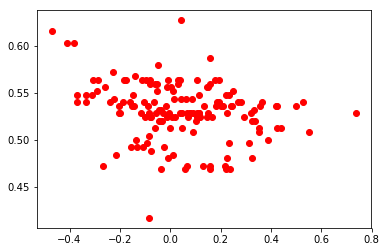

IS_ONE STD SHARPE OOS_ALPHA


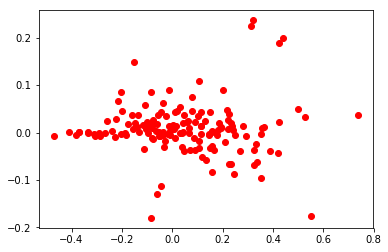

IS_PROFITABILITY OOS_PROFITABILITY


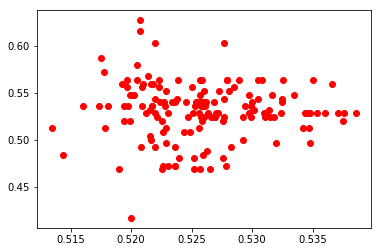

IS_PROFITABILITY OOS_ALPHA


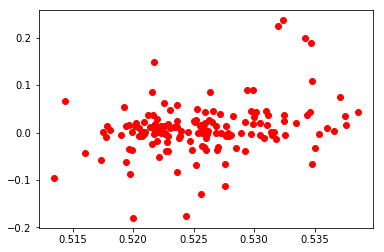

IS_PROFITABILITY SLIPPAGE OOS_PROFITABILITY


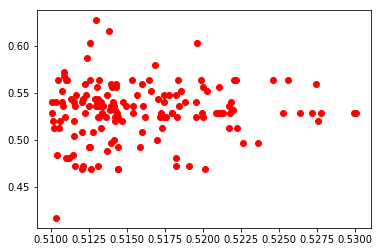

IS_PROFITABILITY SLIPPAGE OOS_ALPHA


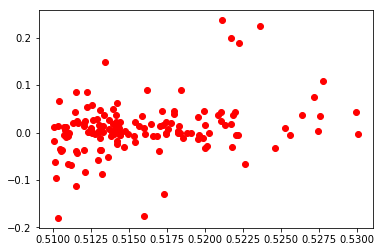

IS_RAW BETA OOS_PROFITABILITY


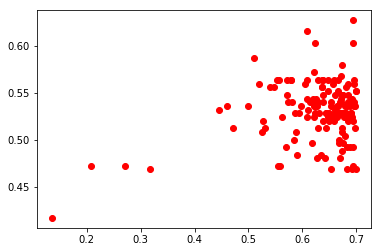

IS_RAW BETA OOS_ALPHA


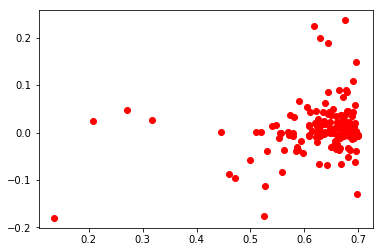

IS_RELATIVE SHARPE OOS_PROFITABILITY


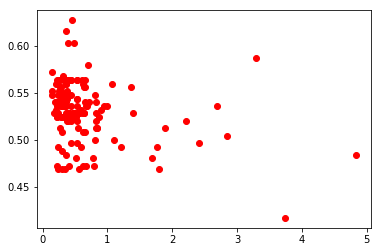

IS_RELATIVE SHARPE OOS_ALPHA


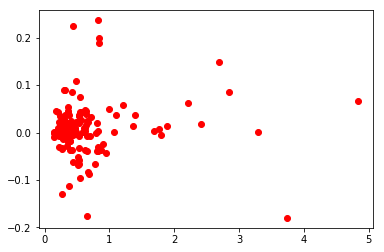

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_PROFITABILITY


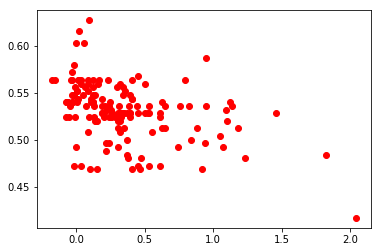

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_ALPHA


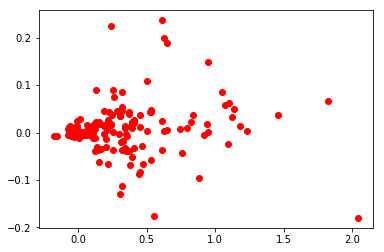

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_PROFITABILITY


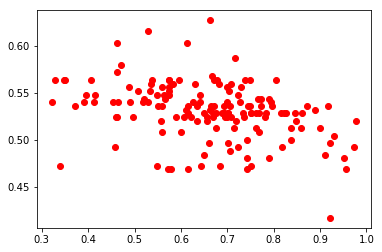

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_ALPHA


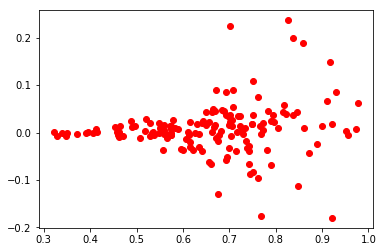

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_PROFITABILITY


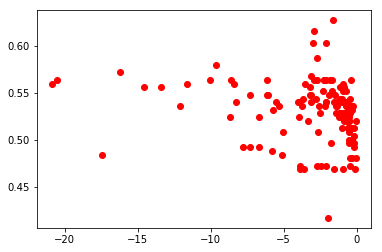

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_ALPHA


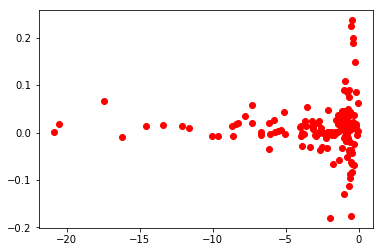

IS_RELATIVE SHARPE SLIPPAGE OOS_PROFITABILITY


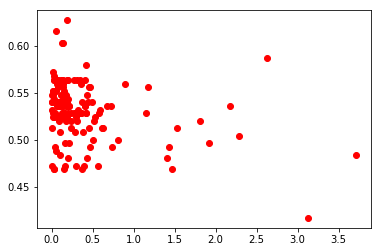

IS_RELATIVE SHARPE SLIPPAGE OOS_ALPHA


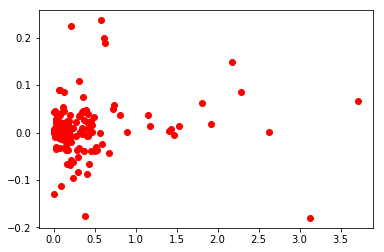

IS_ROLLING SHARPE BETA OOS_PROFITABILITY


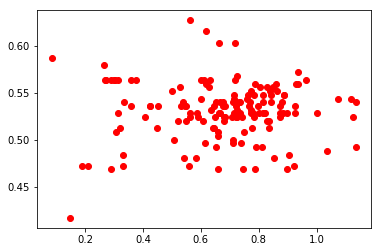

IS_ROLLING SHARPE BETA OOS_ALPHA


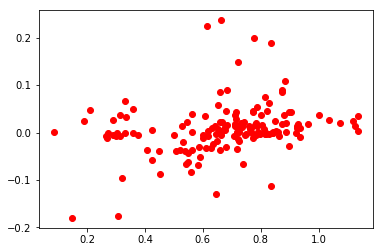

IS_ROLLING SHARPE ERROR OOS_PROFITABILITY


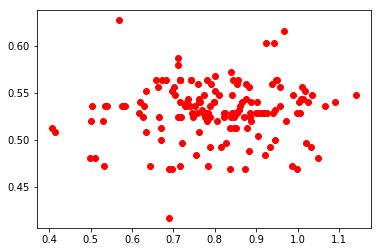

IS_ROLLING SHARPE ERROR OOS_ALPHA


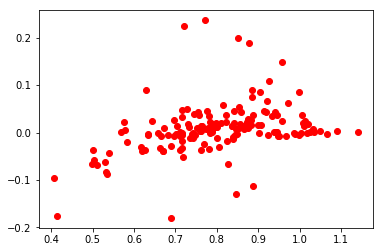

IS_ROLLING SHARPE STABILITY OOS_PROFITABILITY


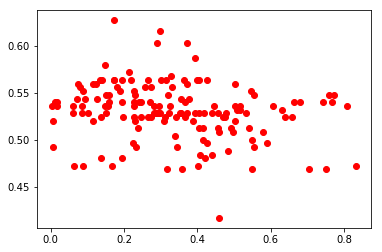

IS_ROLLING SHARPE STABILITY OOS_ALPHA


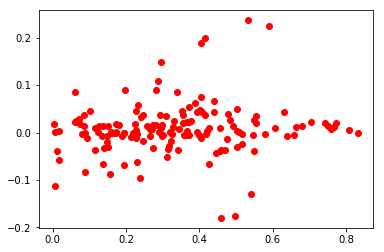

IS_SHARPE OOS_PROFITABILITY


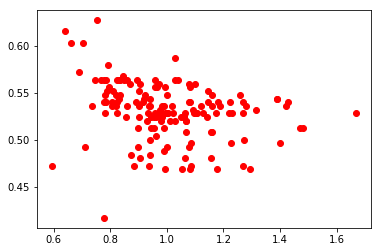

IS_SHARPE OOS_ALPHA


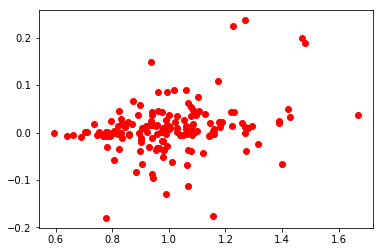

IS_SHARPE DIFFERENCE OOS_PROFITABILITY


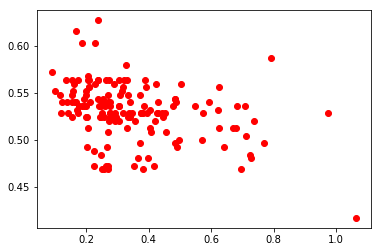

IS_SHARPE DIFFERENCE OOS_ALPHA


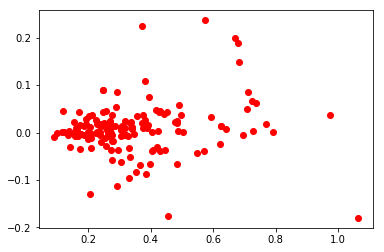

IS_SHARPE DIFFERENCE AVERAGE OOS_PROFITABILITY


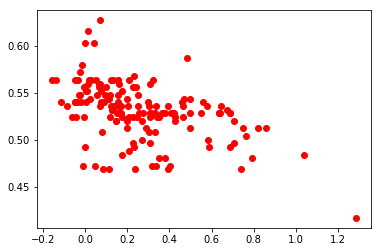

IS_SHARPE DIFFERENCE AVERAGE OOS_ALPHA


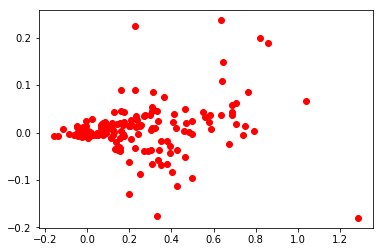

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_PROFITABILITY


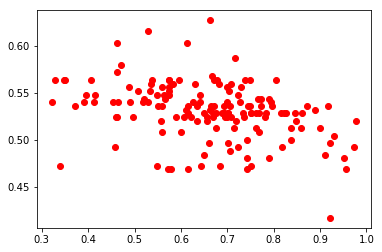

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_ALPHA


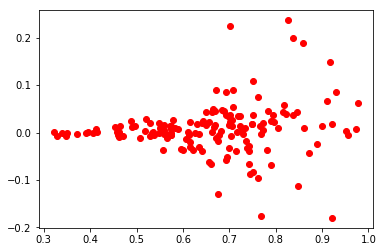

IS_SHARPE DIFFERENCE MIN OOS_PROFITABILITY


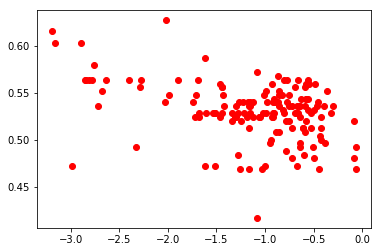

IS_SHARPE DIFFERENCE MIN OOS_ALPHA


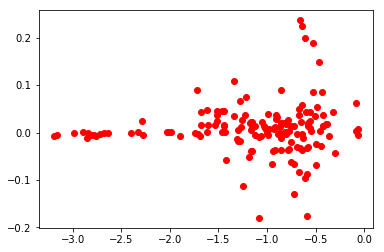

IS_SHARPE DIFFERENCE SLIPPAGE OOS_PROFITABILITY


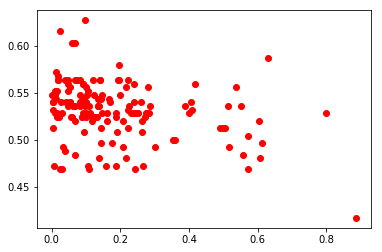

IS_SHARPE DIFFERENCE SLIPPAGE OOS_ALPHA


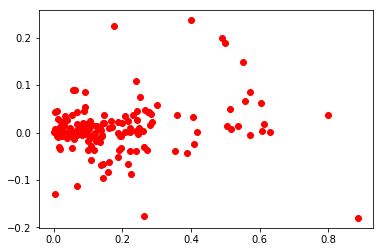

IS_SHARPE SLIPPAGE OOS_PROFITABILITY


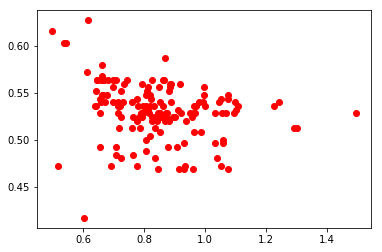

IS_SHARPE SLIPPAGE OOS_ALPHA


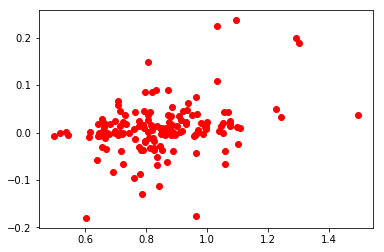

IS_SHARPE SLIPPAGE DECAY OOS_PROFITABILITY


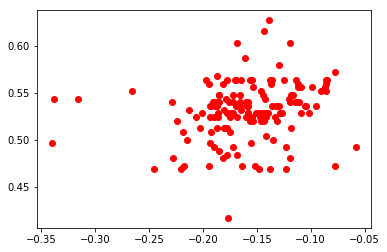

IS_SHARPE SLIPPAGE DECAY OOS_ALPHA


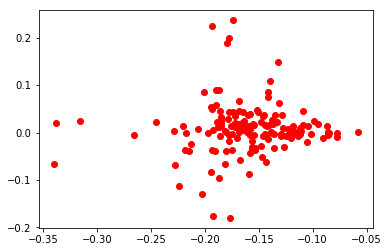

IS_SMART INFORMATION RATIO OOS_PROFITABILITY


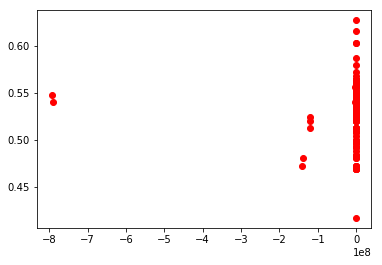

IS_SMART INFORMATION RATIO OOS_ALPHA


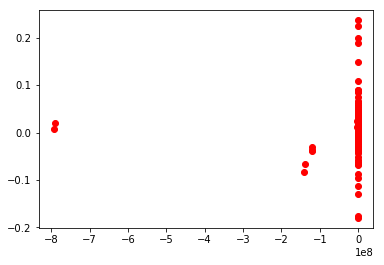

IS_STABILITY OOS_PROFITABILITY


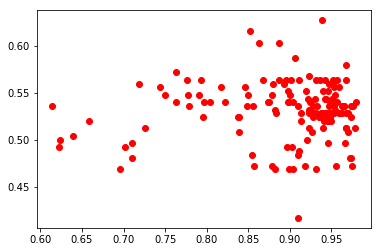

IS_STABILITY OOS_ALPHA


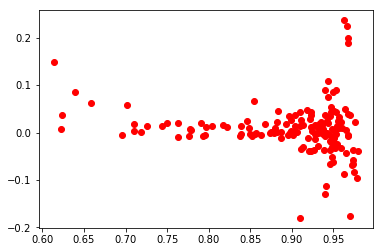

IS_TOTAL DAYS SEEN OOS_PROFITABILITY


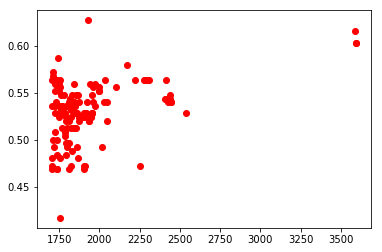

IS_TOTAL DAYS SEEN OOS_ALPHA


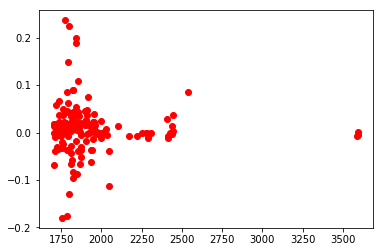

IS_TREYNOR OOS_PROFITABILITY


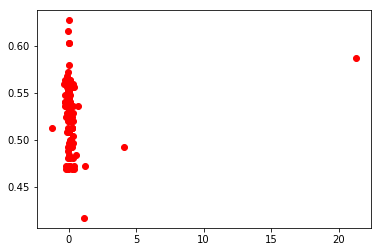

IS_TREYNOR OOS_ALPHA


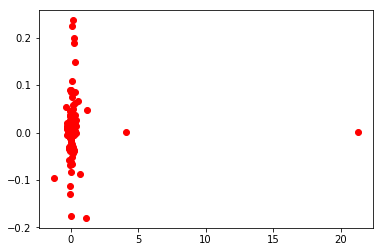

OOS_ALPHA OOS_PROFITABILITY


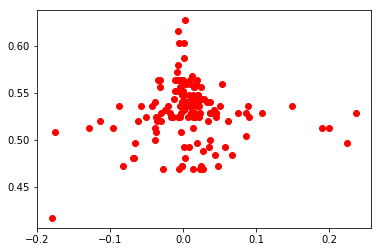

OOS_ALPHA OOS_ALPHA


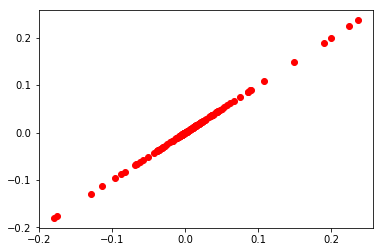

OOS_PROFITABILITY OOS_PROFITABILITY


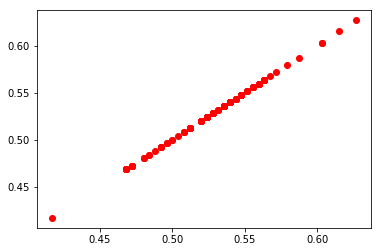

OOS_PROFITABILITY OOS_ALPHA


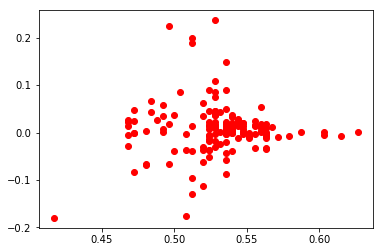

combiner
AND    0.561508
OR     0.529749
Name: OOS_PROFITABILITY, dtype: float64
combiner
AND    0.024198
OR     0.007875
Name: OOS_ALPHA, dtype: float64
combiner OOS_PROFITABILITY
numberOfPredictors
2     0.524943
3     0.538832
4     0.538049
5     0.535962
6     0.516234
7     0.531526
8     0.527778
9     0.522676
10    0.527778
11    0.527778
12    0.525132
Name: OOS_PROFITABILITY, dtype: float64
numberOfPredictors
2     0.000006
3    -0.002132
4     0.007934
5     0.016086
6     0.006397
7     0.004282
8    -0.005220
9     0.049920
10    0.030440
11    0.013516
12    0.011067
Name: OOS_ALPHA, dtype: float64
numberOfPredictors OOS_PROFITABILITY


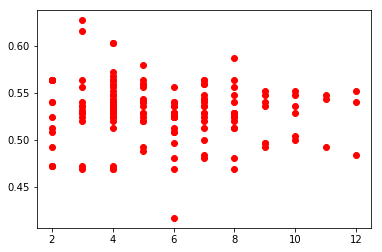

numberOfPredictors OOS_ALPHA


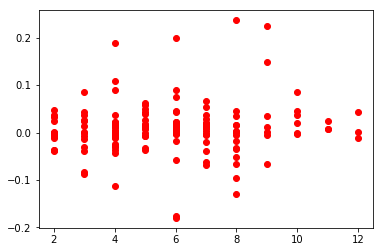

predictionLength
5     0.472222
7     0.506614
10    0.528960
15    0.531979
Name: OOS_PROFITABILITY, dtype: float64
predictionLength
5    -0.001252
7     0.011289
10    0.030685
15   -0.002327
Name: OOS_ALPHA, dtype: float64
predictionLength OOS_PROFITABILITY


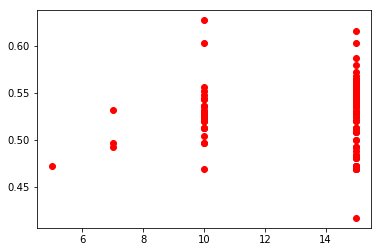

predictionLength OOS_ALPHA


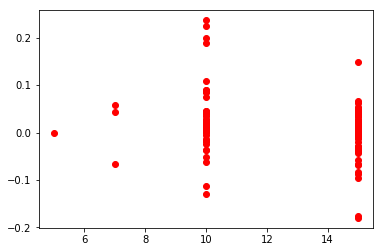

ticker OOS_PROFITABILITY


In [14]:
cm = pd.DataFrame(cleanedModels)
for col in cm.columns.values:
    
    try:
        import matplotlib.pyplot as plt
        groupsSharpe = cm.groupby([col])["OOS_PROFITABILITY"].mean()
        if len(groupsSharpe) < 20:
            print(groupsSharpe)
            print(cm.groupby([col])["OOS_ALPHA"].mean())
        print(col, "OOS_PROFITABILITY")
        xVals = cm[[col]].values
        yVals = cm[["OOS_PROFITABILITY"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        print(col, "OOS_ALPHA")
        xVals = cm[[col]].values
        yVals = cm[["OOS_ALPHA"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        plt.draw()
    except:
        continue
    



In [193]:
cm = pd.DataFrame(cleanedModels).dropna()
cmInput = cm[list(set(cm.columns.values) - set(["OOS_SHARPE DIFFERENCE", "IS_FACTOR SHARPE", "IS_RAW BETA",  "OOS_SHARPE", "OOS_SHARPE SLIPPAGE", "combiner", "ticker"]))]
cmOutput = cm[["OOS_SHARPE DIFFERENCE"]]

In [194]:
cmInput.columns

Index(['IS_EXTREME STABILITY', 'IS_ALPHA SLIPPAGE',
       'IS_25TH PERCENTILE SHARPE DIFFERENCE',
       'IS_RELATIVE SHARPE DIFFERENCE AVERAGE', 'IS_SHARPE', 'IS_TREYNOR',
       'numberOfPredictors', 'IS_SHARPE SLIPPAGE', 'IS_ANNUALIZED RETURN',
       'IS_TOTAL DAYS SEEN', 'IS_ROLLING SHARPE STABILITY',
       'IS_RELATIVE SHARPE', 'IS_SHARPE DIFFERENCE MIN',
       'IS_SMART INFORMATION RATIO', 'IS_ONE STD SHARPE',
       'IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE',
       'IS_SHARPE DIFFERENCE SLIPPAGE', 'IS_SHARPE SLIPPAGE DECAY', 'IS_BETA',
       'IS_ACTIVITY', 'IS_25TH PERCENTILE SHARPE', 'predictionLength',
       'IS_STABILITY', 'IS_SHARPE DIFFERENCE AVERAGE', 'IS_SHARPE DIFFERENCE',
       'IS_RELATIVE SHARPE SLIPPAGE',
       'IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0',
       'IS_ROLLING SHARPE BETA', 'IS_SHARPE DIFFERENCE GREATER THAN 0',
       'IS_EXTREME STABILITY ROLLING 600', 'IS_ALPHA',
       'IS_RELATIVE SHARPE DIFFERENCE MIN', 'IS_ROLLING SHARPE ERROR',


In [195]:
cmInput

,IS_EXTREME STABILITY,IS_ALPHA SLIPPAGE,IS_25TH PERCENTILE SHARPE DIFFERENCE,IS_RELATIVE SHARPE DIFFERENCE AVERAGE,IS_SHARPE,IS_TREYNOR,numberOfPredictors,IS_SHARPE SLIPPAGE,IS_ANNUALIZED RETURN,IS_TOTAL DAYS SEEN,...,IS_SHARPE DIFFERENCE,IS_RELATIVE SHARPE SLIPPAGE,IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0,IS_ROLLING SHARPE BETA,IS_SHARPE DIFFERENCE GREATER THAN 0,IS_EXTREME STABILITY ROLLING 600,IS_ALPHA,IS_RELATIVE SHARPE DIFFERENCE MIN,IS_ROLLING SHARPE ERROR,IS_MIN ROLLING SHARPE
0,0.894353,0.024758,0.175650,0.675437,1.269128,-0.097305,2,0.724259,0.133477,1744,...,0.457949,-0.107153,0.878768,1.018918,0.878768,-0.950010,0.080945,-2.163291,0.895723,-0.354933
1,0.831139,0.006916,-0.695773,-0.129268,0.628492,0.048653,2,0.189506,0.096373,2037,...,0.186871,-0.570886,0.459686,0.387119,0.459686,-0.947509,0.081178,-18.496237,0.619889,-1.124320
2,0.948945,0.013766,-0.251761,0.272559,1.128318,-0.290330,2,0.500083,0.096603,2472,...,0.447959,-0.264972,0.639802,0.194975,0.639802,-0.973024,0.067065,-0.826170,0.490482,0.093114
3,0.900520,0.030273,0.188593,0.818705,0.956416,0.471542,2,0.551259,0.063255,1742,...,0.763158,1.852453,0.798122,0.330278,0.798122,-0.788347,0.057209,-1.470854,0.897204,-0.836832
4,0.568942,-0.033652,-1.167552,-0.388469,0.920025,-1.376700,2,-0.257625,0.098059,1948,...,0.096265,-1.312742,0.353565,0.391514,0.353565,-0.880023,0.093587,-1.600322,0.675868,-0.996843
5,0.966962,-0.125269,-0.560736,-0.211856,0.913847,-0.181762,2,-0.277751,0.131777,1876,...,-0.126452,-1.266991,0.372923,0.330115,0.372923,-0.934339,0.049775,-5.116117,0.793027,-0.868487
6,0.900418,-0.005503,-0.856553,-0.394172,0.816747,-3.541779,2,0.333819,0.022518,1875,...,-0.425210,-0.731215,0.308498,0.267199,0.308498,-0.964373,0.007951,-2.673433,0.862157,-0.405936
7,0.830910,0.025786,-0.467776,-0.144367,0.782197,0.138114,2,0.318984,0.111503,2037,...,0.340576,-0.277697,0.403135,0.581515,0.403135,-0.958367,0.094991,-15.517465,0.782112,-0.734206
8,0.885403,-0.072214,-0.667763,-0.115201,0.828277,-0.203998,2,-0.015408,0.115194,1853,...,-0.060225,-1.017342,0.443196,0.737172,0.443196,-0.930605,0.049284,-25.866522,0.791972,-1.370281
9,0.578649,-0.141544,-0.777884,-0.103535,0.942719,-0.018704,2,-13.449209,0.005750,1850,...,-0.000803,-15.254259,0.428393,1.085181,0.428393,-0.934085,0.003834,-4.605931,0.985889,-1.259068


In [196]:
len(cmOutput[cmOutput > 0].dropna())/len(cmOutput.dropna())

0.3185404339250493

In [197]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [207]:
cmOutput

,OOS_SHARPE DIFFERENCE
0,-0.389076
1,-0.555811
2,0.639304
3,-0.084324
4,0.130381
5,-0.179134
6,-0.011525
7,-0.173473
8,-0.221728
9,1.328103


In [203]:
dtreg = DecisionTreeRegressor(min_samples_leaf=30).fit(cmInput[:750], cmOutput[:750])

In [204]:
tree.export_graphviz(dtreg, out_file='tree.dot')

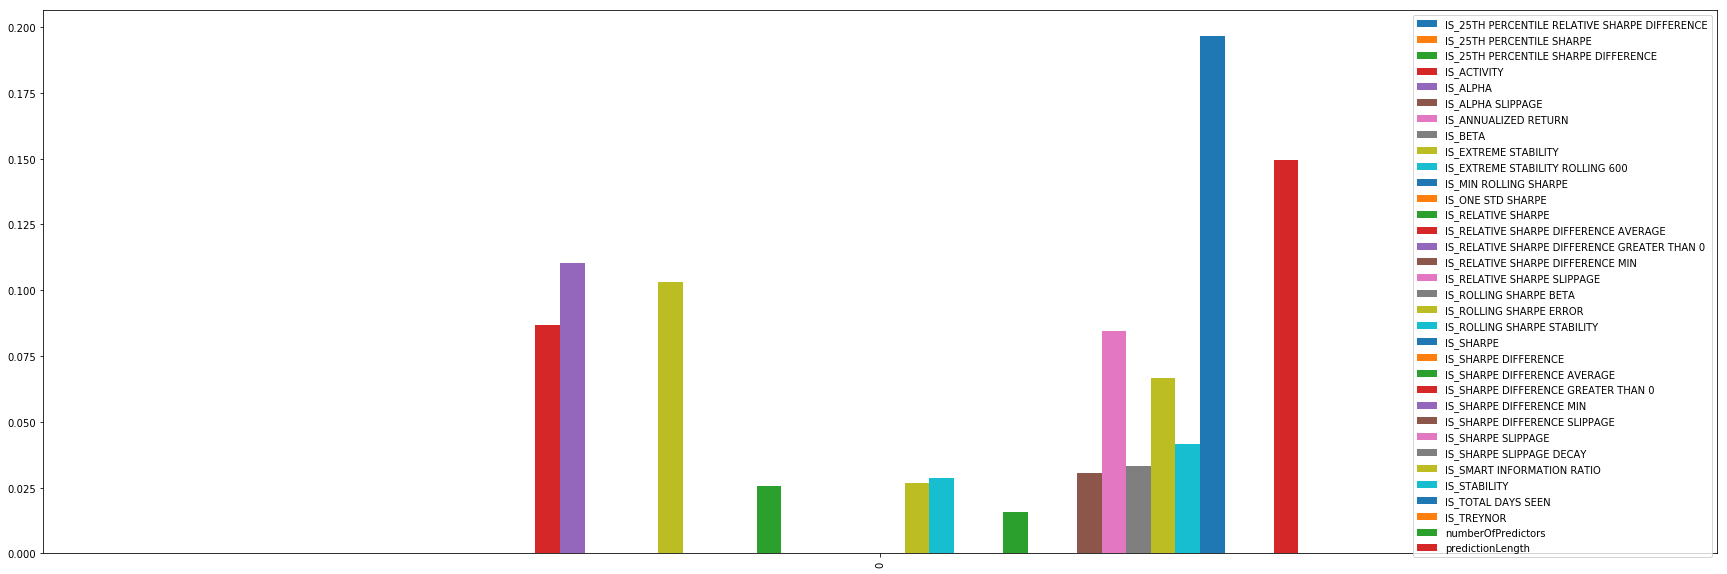

In [205]:
mapper = {}
for i in range(len(cmInput.columns)):
    mapper[cmInput.columns[i]] = dtreg.feature_importances_[i]
%matplotlib inline
pd.DataFrame([mapper]).plot.bar(figsize=(30,10))

In [208]:
pd.DataFrame(dtreg.predict(cmInput[750:]), index=cmOutput[750:].index, columns=["Predicted OOS_SHARPE DIFFERENCE"]).join(cmOutput[750:])

,Predicted OOS_SHARPE DIFFERENCE,OOS_SHARPE DIFFERENCE
751,-0.985127,-0.093945
752,0.239407,0.511387
753,0.239407,0.324767
754,-0.008772,0.716352
755,-0.423803,0.332160
756,0.078780,0.571654
757,-0.389904,0.338736
758,-0.985127,-1.035398
759,0.015560,0.228423
760,-1.334179,-1.683748
